<a href="https://colab.research.google.com/github/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence problems (seq2seq).

## What we're going to learn
* Downloading and preparing a text dataset
* How to prepare text data for modelling (**tokenization and embedding**)
* Setting up multiple modelling experiments with **recurrent neural networks (RNNs)**
* Building a text **feature extraction model using TensorFlow Hub**
* Finding the most wrong prediction examples
* Using a model we've built to make predictions on text from the wild

## Check for GPU

In [119]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [120]:
!wget https://raw.githubusercontent.com/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/refs/heads/main/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2025-08-22 17:57:23--  https://raw.githubusercontent.com/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-08-22 17:57:23 (15.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (test samples of Tweets labelled as diaster or not diaster).

Original source: https://www.kaggle.com/competitions/nlp-getting-started

In [121]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2025-08-22 17:57:24--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 108.177.11.207, 74.125.139.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2025-08-22 17:57:24 (101 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python.
But another way to do this is to use pandas.

In [122]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [123]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [124]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [125]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [126]:
# How many examples of each class have?
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [127]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [128]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real diaster)" if target > 0 else "(not real diaster)")
  print(f"Text:\n {text}\n")
  print("---\n")

Target: 1 (real diaster)
Text:
 2 pple have been confirmed dead and over 20 rescued while many went missing after a ferry carrying 200 collided with a fishing boat.#News

---

Target: 1 (real diaster)
Text:
 NTSB: Virgin Galactic's SpaceshipTwo crash due to structural failure when braking system unlocked early http://t.co/EYSbLYX6L6 via @KPCC @AP

---

Target: 1 (real diaster)
Text:
 Refugio oil spill may have been costlier bigger than projected http://t.co/FPaouLWU3N

---

Target: 1 (real diaster)
Text:
 Unlicensed teen driver among 2 killed in NC crash http://t.co/Woc6AkEHYX

---

Target: 1 (real diaster)
Text:
 Windstorm lastingness perquisite - acquiesce in a twister retreat: ZiUW http://t.co/iRt4kkgsJx

---



### Split data into training and validation sets

For more data: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [129]:
from sklearn.model_selection import train_test_split

In [130]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation
                                                                            random_state=42)

In [131]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [132]:
len(train_df_shuffled)

7613

In [133]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things we'll have to do before we can build a model is to convert our text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number.
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned).

### Text vectorization (tokenization)

In [134]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

Info about `TextVectorization`: [Link](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

In [135]:
import tensorflow as tf
from keras.layers import TextVectorization

In [136]:
# Use the default TextVectorization parameters
text_vextorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do we want our sequences to be?
                                    pad_to_max_tokens=False) # if `max_tokens` has value then it can have `True` or a `number` value

In [137]:
x = train_sentences[0].split()
print(x, "\n", len(x))

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet'] 
 7


In [138]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [139]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [140]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [141]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [142]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\n Vectorized version:")
text_vectorizer([random_sentence])

Original text:
 Slums are a manifestation state failure to provide housing to citizens. Illegality discourse confounds structural problems. #stopevictions        

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[8394,   22,    3,    1,  265,  320,    5, 3509, 2433,    5, 4004,
           1,    1,    1,  384]])>

In [143]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
Bottom 5 least common words: [np.str_('pages'), np.str_('paeds'), np.str_('pads'), np.str_('padres'), np.str_('paddytomlinson1')]


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary.
* `output_dim` = the size of the output embedding vector, for example: a value of 100 would mean each token gets represented by a vector 100 long.
* `input_length` = length of the sequences being passed to the embedding layer.

In [144]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length # how long is each input
                             )
embedding

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [145]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 pic of me and blaze in a fort when we were kids i look like a jackass stuffin my face like that ?????? http://t.co/aE9cPIexAK        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01232814,  0.03288176,  0.02328658, ...,  0.00411187,
         -0.02609721, -0.04970151],
        [ 0.015046  ,  0.01003649, -0.00883821, ...,  0.04835853,
          0.04700381,  0.03937124],
        [-0.04681312, -0.02001929, -0.02541186, ..., -0.03855335,
         -0.03279799,  0.00732254],
        ...,
        [-0.02701229,  0.01697654,  0.03582549, ...,  0.02845112,
          0.04347939, -0.0361435 ],
        [-0.00106127, -0.00178682,  0.02285887, ..., -0.04001888,
         -0.03304359,  0.0216367 ],
        [ 0.04544336, -0.00236762, -0.02902919, ...,  0.04210417,
         -0.03773789, -0.04973918]]], dtype=float32)>

In [146]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.01232814,  0.03288176,  0.02328658,  0.00792853,  0.02276259,
         0.01668999,  0.03469509,  0.03874339, -0.04968206,  0.03238453,
         0.0239062 ,  0.02719501,  0.02373015,  0.01242042, -0.01435392,
        -0.01120446, -0.04829542,  0.01176327,  0.03406293, -0.01678145,
        -0.00905837,  0.03929304,  0.03636935,  0.03933312, -0.02470478,
        -0.03860189, -0.04684535,  0.00394831,  0.02191465,  0.03571402,
        -0.04919025, -0.03219283,  0.00162524, -0.04480721, -0.00646173,
        -0.04444472, -0.03784012,  0.0036255 , -0.00902417, -0.02501711,
         0.0349491 , -0.04579141,  0.04778368, -0.02657109,  0.02701985,
         0.01263437,  0.03607881,  0.00919688,  0.01612897, -0.03354652,
         0.02672423, -0.01959856, -0.02280126, -0.04218921,  0.03023538,
         0.01177274,  0.02601527,  0.0227248 , -0.00279659, -0.04983097,
        -0.00240581,  0.03090196,  0.02811554, -0.00559367, -0.04545606,
  

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/1.3/tutorial/machine_learning_map/
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data


We are going to approach all of these by using the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

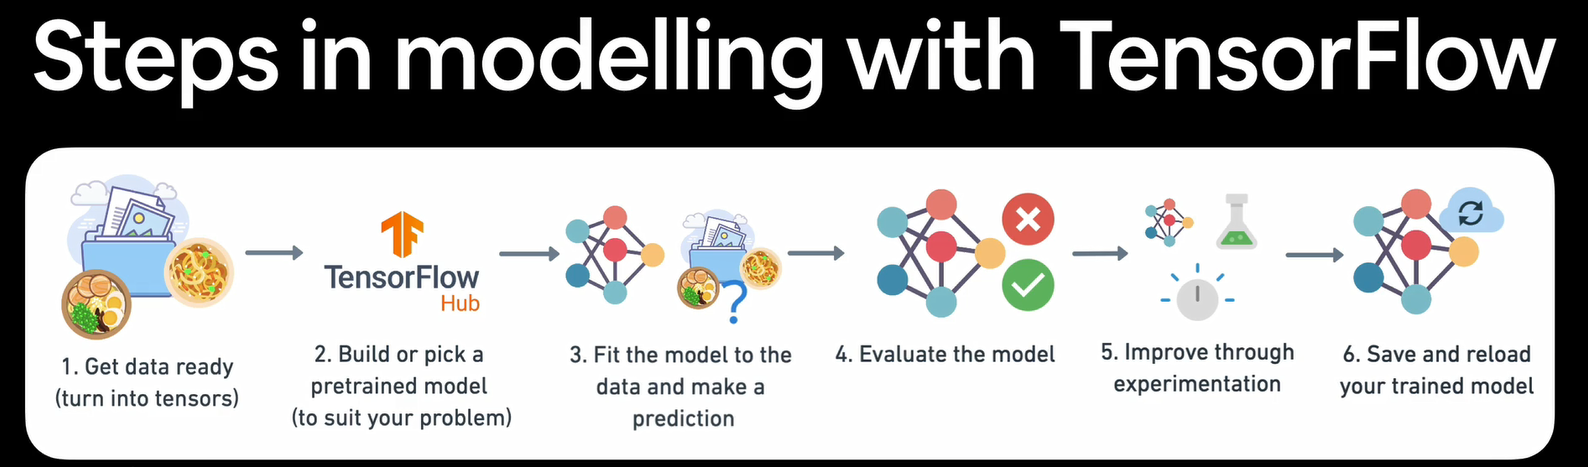

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so we've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.
> 🔑**Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if we can improve upon them.

In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [148]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [149]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [150]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [151]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function.

Let's create a function to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

> For a deep overview of many different evaluation methods, **Scikit-learn Link:** [3.3. Model evaluation: quantifying the quality of predictions](https://scikit-learn.org/0.16/modules/model_evaluation.html)

> Another link for **model evaluation methods:** [Model selection and evaluation](https://scikit-learn.org/stable/model_selection.html)

In [152]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  ---
  y_true: true labels in the form of a 1D array
  y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [153]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [154]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [155]:
# Build model with the Functional API
from tensorflow.keras import layers
import tensorflow as tf

inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
# Flatten / Global Pool before Dense
# If we want one prediction per sentence (binary classification), reduce the sequence to a single vector before the final Dense.
# Or it will have error, because model's output shape and our label shape won't match
x = layers.GlobalAveragePooling1D()(x) # pool over sequence length - condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x)  # create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [156]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [157]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [158]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20250822-175726
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6364 - loss: 0.6502 - val_accuracy: 0.7703 - val_loss: 0.5360
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8131 - loss: 0.4633 - val_accuracy: 0.7808 - val_loss: 0.4713
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8636 - loss: 0.3525 - val_accuracy: 0.7887 - val_loss: 0.4686
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8899 - loss: 0.2858 - val_accuracy: 0.7808 - val_loss: 0.4640
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9106 - loss: 0.2410 - val_accuracy: 0.7887 - val_loss: 0.4868


In [159]:
print(train_sentences.ndim)
print(train_labels.ndim)

1
1


In [160]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7794 - loss: 0.5222


[0.4868149757385254, 0.7887139320373535]

In [161]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(762, 1)

In [162]:
model_1_pred_probs[0]

array([0.27514184], dtype=float32)

In [163]:
# Look at the 1st 10 predictions
model_1_pred_probs[:10]

array([[0.27514184],
       [0.7806757 ],
       [0.9979608 ],
       [0.09605666],
       [0.08540815],
       [0.9240882 ],
       [0.90604794],
       [0.99257845],
       [0.95041096],
       [0.22131711]], dtype=float32)

In [164]:
# Convert model predictions probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.],
      dtype=float32)>

In [165]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7975437468825353,
 'recall': 0.7887139107611548,
 'f1': 0.7845609441537968}

In [166]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [167]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [168]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000,
 ['',
  '[UNK]',
  np.str_('the'),
  np.str_('a'),
  np.str_('in'),
  np.str_('to'),
  np.str_('of'),
  np.str_('and'),
  np.str_('i'),
  np.str_('is')])

In [169]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [170]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
# embed_weights = model_1.get_layer("embedding").get_weights()[0]
# the code gets error when we rerun the program, let's create a try, except function
# Try to get embedding weights whether the layer is named "embedding" or "embedding_1"
try:
    embed_weights = model_1.get_layer("embedding").get_weights()[0]
except ValueError:
    embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
embed_weights

array([[ 0.05497823,  0.05753805, -0.01267279, ...,  0.02743377,
        -0.02089258,  0.01226554],
       [ 0.00324856,  0.02820004,  0.03659345, ..., -0.03552964,
        -0.02123518,  0.05224422],
       [ 0.04098302,  0.03937174, -0.00217601, ..., -0.01632541,
         0.02017931,  0.02932698],
       ...,
       [-0.02064375, -0.00989561, -0.041958  , ..., -0.00297601,
        -0.02592741, -0.00719255],
       [ 0.03520752,  0.04752171,  0.07934637, ..., -0.08164984,
        -0.02931722,  0.03374666],
       [ 0.04472686,  0.09542832,  0.0972265 , ..., -0.0808193 ,
        -0.01908251,  0.01187816]], dtype=float32)

In [171]:
print(embed_weights.shape) # same size as vocab size and embedding dim (output dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embedding themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [172]:
# Create embedding files (we got this trom TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  # if we apply the original code then the `IndexError` in our loop will happen because `words_in_vocab` is longer than `embed_weights`.
  # we add this next `if` function
  # if index >= embed_weights.shape[0]:
  #   break  # avoid going past available embeddings
  # [this apply when we use get_weights() insted of get_weights()[0] in embed_weights]
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

But, If we want the embedding files for TensorBoard projector to work correctly, other option is better — because we want an embedding for every token in the vocabulary.

And that is: Match embedding input_dim to vocabulary size
When creating the embedding layer:

`vocab_size = len(words_in_vocab)
embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim
)`



In [173]:
# Download files from Colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

Downloading the files above we can visualize them using https://projector.tensorflow.org/ and clicking the "load" button on the left hand side.
> 📖 **Resources:** For better understanding embeddings, check out:
* Jay Alammar's visualized word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/text/guide/word_embeddings

## Recurrent Neural Networks (RNN's)

**RNN's are useful for sequence data.**

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

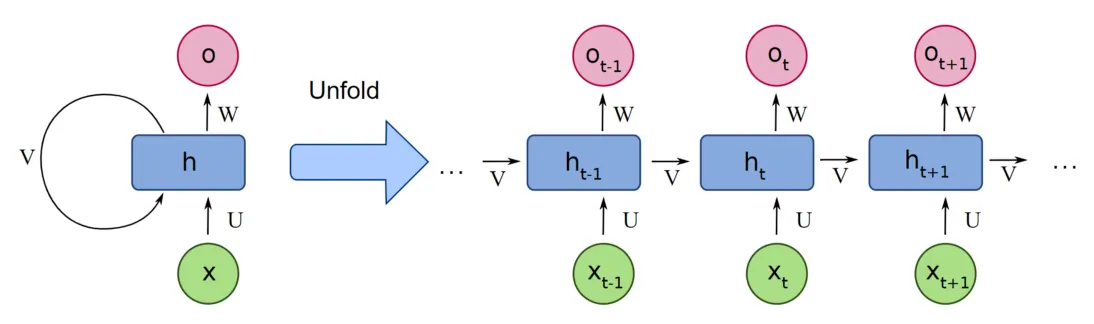

For better understanding: **MIT deep learning course:** https://introtodeeplearning.com/

In [174]:
train_sentences[:20]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt',
       'Lava Dragon Breeder! I just bred a 

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

For more information: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

Our structure of an RNN typically looks like this:

```
Inpur (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Outpur (label probability)
```

In [175]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)  # when we're stacking RNN cells together, we need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [176]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [177]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [178]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20250822-175811
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8881 - loss: 0.3090 - val_accuracy: 0.7756 - val_loss: 0.5496
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9453 - loss: 0.1587 - val_accuracy: 0.7730 - val_loss: 0.6305
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9547 - loss: 0.1236 - val_accuracy: 0.7769 - val_loss: 0.6559
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9614 - loss: 0.1007 - val_accuracy: 0.7848 - val_loss: 0.8220
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9667 - loss: 0.0837 - val_accuracy: 0.7822 - val_loss: 0.9576


In [179]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


array([[2.2924038e-02],
       [8.6297554e-01],
       [9.9985892e-01],
       [6.0446929e-02],
       [6.2959857e-04],
       [9.9965703e-01],
       [8.5282415e-01],
       [9.9989253e-01],
       [9.9983233e-01],
       [4.6526000e-01]], dtype=float32)

In [180]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [181]:
# calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 78.21522309711287,
 'precision': 0.7831103148931962,
 'recall': 0.7821522309711286,
 'f1': 0.7806413638617516}

In [182]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [183]:
np.array(list(model_2_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit. TensorFlow Link: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

Another great resources: https://towardsdatascience.com/gru-recurrent-neural-networks-a-smart-way-to-predict-sequences-in-python-80864e4fe9f6/

The GRU cell has similar features to an LSTM cell but has less parameters.

In [184]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# or we can just add a GRU layer without return_sequences=True
x = layers.GRU(64)(x)
# x = layers.GRU(64, return_sequences=True)(x) # if we want to stack recurrent layers on top of each other, we need return_sequences=True
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [185]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [186]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [187]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20250822-175858
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.8695 - loss: 0.2738 - val_accuracy: 0.7769 - val_loss: 0.7259
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9714 - loss: 0.0796 - val_accuracy: 0.7808 - val_loss: 0.8846
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9769 - loss: 0.0613 - val_accuracy: 0.7703 - val_loss: 0.9708
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9765 - loss: 0.0601 - val_accuracy: 0.7730 - val_loss: 1.1520
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9788 - loss: 0.0453 - val_accuracy: 0.7677 - val_loss: 1.3287


In [188]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


array([[5.9266733e-03],
       [8.6927360e-01],
       [9.9994779e-01],
       [2.6136059e-01],
       [6.9812762e-05],
       [9.9992239e-01],
       [9.4528592e-01],
       [9.9997383e-01],
       [9.9995208e-01],
       [9.9903983e-01]], dtype=float32)

In [189]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [190]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7673725996279359,
 'recall': 0.7677165354330708,
 'f1': 0.7670623230765294}

In [191]:
np.array(list(model_3_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like we read an English sentence). However, a bidirectional RNN goes from right to left as well as left to right.

In [192]:
# Build a Bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# print(x.shape)
# x = layers.Bidirectional(layers.GRU(64))(x)
# print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)  # keeping it simple to understand better
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [193]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [194]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [195]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20250822-175943
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.9642 - loss: 0.1873 - val_accuracy: 0.7717 - val_loss: 0.9579
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9796 - loss: 0.0499 - val_accuracy: 0.7625 - val_loss: 0.9949
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9801 - loss: 0.0454 - val_accuracy: 0.7690 - val_loss: 1.2190
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9803 - loss: 0.0420 - val_accuracy: 0.7756 - val_loss: 1.5323
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9798 - loss: 0.0419 - val_accuracy: 0.7756 - val_loss: 1.1791


In [196]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


array([[9.0310453e-03],
       [6.7094457e-01],
       [9.9984431e-01],
       [2.7431005e-01],
       [3.0991185e-05],
       [9.9901682e-01],
       [8.6872703e-01],
       [9.9991566e-01],
       [9.9981129e-01],
       [8.4186405e-01]], dtype=float32)

In [197]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [198]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.55905511811024,
 'precision': 0.7774694686899193,
 'recall': 0.7755905511811023,
 'f1': 0.7734917819402004}

In [199]:
np.array(list(model_4_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [200]:
import pandas as pd

results = [baseline_results, model_1_results, model_2_results, model_3_results]

df = pd.DataFrame(results, index=["baseline_results", "model_1_results", "model_2_results", "model_3_results"])

# Highlight maximum values in each column
styled_df = df.style.highlight_max(axis=0, color="lightgreen").format("{:.4f}")

styled_df

,accuracy,precision,recall,f1
baseline_results,79.2651,0.8111,0.7927,0.7862
model_1_results,78.8714,0.7975,0.7887,0.7846
model_2_results,78.2152,0.7831,0.7822,0.7806
model_3_results,76.7717,0.7674,0.7677,0.7671


## Convolution Neural Networks for Text (and other types of sequences)


We've used CNNs for images but images are typically 2D (height x width). However, our text data is 1D.

The typical structure of a Conv1D model for sequences:
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

For more information: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

### Model 5: Conv1D

For different explanations of parameters see:
* This is for 2D but can relate to 1D data: https://poloclub.github.io/cnn-explainer/
* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

> Extra Note: What `relu` does: https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

In [201]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1, # default
                        activation="relu",
                        padding="valid") # default = "valid", the output is smaller than the input shape, "same" means output is same shape as input
conv_1d_output = conv_1d(embedding_test) # pass text embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D() # we used conv1d layer thats why maxpool1d, if it is conv2d we'll used maxpool2d
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [202]:
# embedding_test

In [203]:
# conv_1d_output

In [204]:
# max_pool_output

In [205]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our model
model_5.summary()

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 11, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,089 (5.04 MB)

 Trainable params: 1,321,089 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [206]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20250822-180035
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9493 - loss: 0.1821 - val_accuracy: 0.7769 - val_loss: 0.8707
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9723 - loss: 0.0776 - val_accuracy: 0.7651 - val_loss: 1.0427
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9769 - loss: 0.0596 - val_accuracy: 0.7598 - val_loss: 1.1376
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9802 - loss: 0.0498 - val_accuracy: 0.7533 - val_loss: 1.1617
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9819 - loss: 0.0439 - val_accuracy: 0.7638 - val_loss: 1.1899


In [207]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


array([[8.79110768e-02],
       [5.78127980e-01],
       [9.99845326e-01],
       [7.08012357e-02],
       [1.10469955e-07],
       [9.94009852e-01],
       [9.77565169e-01],
       [9.99989629e-01],
       [9.99997914e-01],
       [9.40277159e-01]], dtype=float32)

In [208]:
# Convert model_5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [209]:
# Evaluate model_5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.37795275590551,
 'precision': 0.7639261289761722,
 'recall': 0.7637795275590551,
 'f1': 0.7624822674694383}

In [210]:
# Compare the results with the baseline_model
np.array(list(model_5_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2

A good resource: https://www.kaggle.com/code/anantjain1223/universal-sentence-encoder

In [211]:
import tensorflow_hub as hub
embed = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
embed_samples = embed([sample_sentence,
                       "When you implement the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [212]:
embed_samples[0].shape

TensorShape([512])

In [213]:
# Create a Keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

**Custom wrapper layer so Sequential accepts it:** Use the code from [stackoverflow](https://stackoverflow.com/questions/78530756/error-only-instances-of-keras-layer-can-be-added-to-a-sequential-model) to solve the problem of Sequential accepting the layers from `hub.KerasLayer`

In [214]:
# Create model using the Sequential API
import tf_keras

model_6 = tf_keras.Sequential([
  sentence_encoder_layer,
  tf_keras.layers.Dense(64, activation="relu"),
  tf_keras.layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Because we are using `tf_keras` so we cannot use `create_tensorboard_callback` in callbacks. So we create a `tensorboard_callback` which is approprite for the `tf_keras`.

In [215]:
from tf_keras.callbacks import TensorBoard   # import from tf_keras, not tensorflow.keras
import datetime

# Log directory
log_dir = "model_logs/tf_hub_sentence_encoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# TensorBoard callback
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

In [216]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[tensorboard_callback])

Epoch 1/5
215/215 [==============================] - 91s 404ms/step - loss: 0.5012 - accuracy: 0.7825 - val_loss: 0.4483 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 73s 340ms/step - loss: 0.4150 - accuracy: 0.8155 - val_loss: 0.4389 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 73s 342ms/step - loss: 0.3997 - accuracy: 0.8216 - val_loss: 0.4317 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 78s 362ms/step - loss: 0.3933 - accuracy: 0.8253 - val_loss: 0.4298 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 73s 342ms/step - loss: 0.3855 - accuracy: 0.8288 - val_loss: 0.4262 - val_accuracy: 0.8123


In [217]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 18ms/step


array([[0.19693169],
       [0.79471177],
       [0.9890117 ],
       [0.22777885],
       [0.72344935],
       [0.7585028 ],
       [0.9844371 ],
       [0.9809041 ],
       [0.94290596],
       [0.09583063]], dtype=float32)

In [218]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [219]:
val_labels[:50]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0])

In [220]:
# Calculate model_6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8140043704592863,
 'recall': 0.8123359580052494,
 'f1': 0.8109868382392855}

In [221]:
np.array(list(model_6_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when we don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [287]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data outperforms model_6 trained on full data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SETS

# # Create subset of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# # print(train_10_percent.head(), len(train_10_percent))
# # print(len(train_df_shuffled))
# train_sentences_10_percent_1 = train_10_percent["text"].to_list()
# train_labels_10_percent_1 = train_10_percent["target"].to_list()
# len(train_sentences_10_percent_1), len(train_labels_10_percent_1)

In [288]:
# # Check the number of targets in our subset of data
# train_10_percent["target"].value_counts()

In [289]:
# # Check the number of targets in our main set of data to see if the target have similar ratio
# train_df_shuffled["target"].value_counts()

To recreate a model the same as a previous model we're created we can use the `tf.keras.models.clone_model()` method, more information: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model



> 🔑**Note:** Model cloning is similar to calling a model on new inputs, except that it creates new layers (and thus new weights) instead of sharing the weights of the existing layers.

> ❎ As we used `tf_keras` for custom wrapper layer so Sequential accepts it in **`model_6`**. Here also we will use `tf_keras` insted of `tf.keras`.

In [290]:
# # Let's build a model the same as model_6
# model_7_clone_of_6 = tf_keras.models.clone_model(model_6)

# # Compile model
# model_7_clone_of_6.compile(loss="binary_crossentropy",
#                 optimizer=tf_keras.optimizers.Adam(),
#                 metrics=["accuracy"])

# # Get a summary (will be same as model_6)
# model_7_clone_of_6.summary()

In [291]:
# But let's build model_7
import tf_keras

model_7 = tf_keras.Sequential([
  sentence_encoder_layer,
  tf_keras.layers.Dense(64, activation="relu"),
  tf_keras.layers.Dense(1, activation="sigmoid")
], name="model_7_USE")

# Compile
model_7.compile(loss="binary_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_9 (Dense)             (None, 64)                32832     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [292]:
# # Fit the model to the 10% training data subsets
# model_7_history_1 = model_7.fit(train_sentences_10_percent_1,
#                               train_labels_10_percent_1,
#                               epochs=5,
#                               validation_data=(val_sentences, val_labels),
#                               callbacks=[tensorboard_callback])

In [293]:
# # Make predictions with the model trained on 10% of the data
# model_7_pred_probs_1 = model_7.predict(val_sentences)
# model_7_pred_probs_1[:10]

In [294]:
# # Turn pred probs into labels
# model_7_preds_1 = tf.squeeze(tf.round(model_7_pred_probs_1))
# model_7_preds_1[:10]

In [295]:
# # Evaluate model 7 predictions
# model_7_results_1 = calculate_results(y_true=val_labels,
#                                     y_pred=model_7_preds_1)
# model_7_results_1

In [296]:
# np.array(list(model_7_results_1.values())) > np.array(list(model_6_results.values()))

> Here we see that the `model_7` performs better than `model_6` with smaller dataset. But it should not be happened. It's because of how we created the later version of dataset, `train_10_percent`. It's called **data leakage** problem. More information: https://www.kaggle.com/code/alexisbcook/data-leakage

In [297]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
print(f"len(train_sentences_10_percent): {len(train_sentences_10_percent)}, "
      f"\nlen(train_sentences): {len(train_sentences)}, "
      f"\nlen(train_labels_10_percent): {len(train_labels_10_percent)}, "
      f"\nlen(train_labels): {len(train_labels)}")

len(train_sentences_10_percent): 685, 
len(train_sentences): 6851, 
len(train_labels_10_percent): 685, 
len(train_labels): 6851


In [298]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

,count
0,406
1,279


In [299]:
train_df_shuffled["target"].value_counts()

,count
target,
0,4342
1,3271


In [300]:
# Fit the model_7 to the new 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[tensorboard_callback])

Epoch 1/5
22/22 [==============================] - 79s 4s/step - loss: 0.6768 - accuracy: 0.6394 - val_loss: 0.6557 - val_accuracy: 0.7349
Epoch 2/5
22/22 [==============================] - 76s 4s/step - loss: 0.6111 - accuracy: 0.8029 - val_loss: 0.5979 - val_accuracy: 0.7612
Epoch 3/5
22/22 [==============================] - 75s 4s/step - loss: 0.5382 - accuracy: 0.8102 - val_loss: 0.5421 - val_accuracy: 0.7664
Epoch 4/5
22/22 [==============================] - 76s 4s/step - loss: 0.4742 - accuracy: 0.8219 - val_loss: 0.5099 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 74s 4s/step - loss: 0.4318 - accuracy: 0.8248 - val_loss: 0.4887 - val_accuracy: 0.7717


In [301]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.24173746],
       [0.6369371 ],
       [0.92658144],
       [0.3627192 ],
       [0.52510524],
       [0.7691874 ],
       [0.8967409 ],
       [0.8236164 ],
       [0.84387547],
       [0.17301883]], dtype=float32)

In [302]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [303]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.16535433070865,
 'precision': 0.7716675722378594,
 'recall': 0.7716535433070866,
 'f1': 0.7706024774352979}

In [304]:
np.array(list(model_7_results.values())) > np.array(list(model_6_results.values()))

array([False, False, False, False])

In [305]:
import pandas as pd

results = [baseline_results, model_6_results, model_7_results]

df = pd.DataFrame(results, index=["baseline_results", "model_6_results", "model_7_results"])

# Highlight maximum values in each column
model_6_vs_model_7 = df.style.highlight_max(axis=0, color="lightgreen").format("{:.4f}")

model_6_vs_model_7

,accuracy,precision,recall,f1
baseline_results,79.2651,0.8111,0.7927,0.7862
model_6_results,81.2336,0.8140,0.8123,0.8110
model_7_results,77.1654,0.7717,0.7717,0.7706


> 🔑 **Note:** Be *very* careful when creating training/val/test splits that we don't leak data across the datasets, otherwise our model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust own gut and go back through to find where the error may lie.

End of 27